In [13]:
from keras import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.datasets import imdb
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [14]:
ds = pd.read_csv('dataset.csv', header=0, index_col=0)
ds.drop(ds.columns[[0,1,2]], axis=1, inplace=True)
ds.head(10)

,Close,Volume,Return,Vol-5d,MACD,RSI,EMA,MFI,signal
Date,,,,,,,,,
2002-01-23,0.352438,443279200,0.054994,0.050050,0.001683,56.879586,0.337801,46.200427,0.0
2002-01-24,0.355347,344002400,0.008254,0.035992,0.002980,57.971201,0.340991,43.558844,0.0
2002-01-25,0.355960,185914400,0.001725,0.030221,0.004011,58.211280,0.343713,37.623011,0.0
2002-01-28,0.356266,186446400,0.000860,0.004042,0.004798,58.339253,0.345995,43.231508,0.0
2002-01-29,0.353204,240324000,-0.008596,0.005726,0.005115,56.475804,0.347306,45.017739,0.0
2002-01-30,0.368821,471576000,0.044215,0.028161,0.006551,62.971166,0.351218,53.068812,0.0
2002-01-31,0.378466,468445600,0.026152,0.024034,0.008371,66.314793,0.356172,61.861927,1.0
2002-02-01,0.373719,398305600,-0.012541,0.024336,0.009323,63.286365,0.359362,62.619601,1.0
2002-02-04,0.388111,522373600,0.038509,0.026633,0.011110,68.050701,0.364589,70.915639,1.0


In [15]:
vals = ds.values #2d array, 5003 records
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled = scaler.fit_transform(vals) #standardize the dataset
df = pd.DataFrame(scaled, columns = ds.columns.values)
header = df.columns
scaled_vals = df.values.astype('float32')
header

Index(['Close', 'Volume', 'Return', 'Vol-5d', 'MACD', 'RSI', 'EMA', 'MFI',
       'signal'],
      dtype='object')

In [16]:
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:clean_agg = agg.dropna()
    return clean_agg

In [17]:
data = series_to_supervised(scaled_vals, header, 5)
drops = [x for x in range(len(ds.columns),len(data.columns)-1)]
data.drop(data.columns[drops], axis=1, inplace=True)
data.head(10)

,Close(t-5),Volume(t-5),Return(t-5),Vol-5d(t-5),MACD(t-5),RSI(t-5),EMA(t-5),MFI(t-5),signal(t-5),signal(t)
5,0.000918,0.121171,0.735878,0.368821,0.380325,0.534827,0.000814,0.462004,0.0,0.0
6,0.000936,0.091391,0.589009,0.265155,0.380432,0.549493,0.000834,0.435588,0.0,1.0
7,0.000939,0.043968,0.568494,0.222596,0.380517,0.552719,0.000851,0.376230,0.0,1.0
8,0.000941,0.044128,0.565775,0.029550,0.380582,0.554438,0.000865,0.432315,0.0,1.0
9,0.000923,0.060290,0.536062,0.041962,0.380609,0.529402,0.000873,0.450177,0.0,1.0
10,0.001017,0.129659,0.702008,0.207403,0.380728,0.616670,0.000898,0.530688,0.0,1.0
11,0.001076,0.128720,0.645249,0.176972,0.380878,0.661593,0.000928,0.618619,1.0,0.0
12,0.001047,0.107680,0.523666,0.179202,0.380957,0.620905,0.000948,0.626196,1.0,0.0
13,0.001134,0.144897,0.684079,0.196141,0.381105,0.684915,0.000981,0.709156,1.0,1.0
14,0.001143,0.125253,0.575464,0.191865,0.381221,0.691201,0.001009,0.721159,1.0,0.0


In [18]:
dataset = data.values 
print(dataset.shape)
train = dataset[:3000, :]
test = dataset[3000:,:]

(4996, 10)


In [19]:
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

In [20]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [21]:
def LSTM_Model(x_train):

    model = Sequential()
    model.add(LSTM(100,activation='sigmoid',input_shape = (x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    return model

In [22]:
def trainLSTM(x_train, y_train):  
    model = LSTM_Model(x_train)
    past = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=72)
    return past

In [23]:
history = trainLSTM(x_train, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 44,101
Trainable params: 44,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
42/42 [==============================] - 3s 15ms/step - loss: 0.7021 - accuracy: 0.5100 - val_loss: 0.6849 - val_accuracy: 0.5631
Epoch 2/5
42/42 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.6267 - val_loss: 0.6754 - val_accuracy: 0.6207
Epoch 3/5
42/42 [==============================] - 0s 5ms/step - loss: 0.6612 - accuracy: 0.6340 - val_loss: 0.6667 - val_accuracy: 0.6253
Epoch 4/5
42/42 [==============================] - 0s 5ms/step - loss: 0.6517 - accuracy:

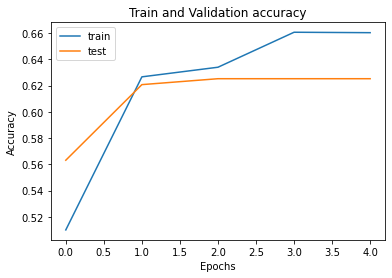

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Train and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()